In [445]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math
import PIL 

clean data -- create directory to hold images.

In [446]:
#directories
face_csv_filepath = 'data/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [447]:
#load csv
def face_csv_to_df(csv_pathname):
    
    directory = os.getcwd() #returns path to current directory
    try:
        #create dataframe containing image expression label number, usage, and pixels.
        facedata = pd.read_csv(os.path.join(directory, csv_pathname))
        print("Dataframe of CSV successfully created.")
    except:
        print("Issue raised creating dataframe.")
        return 0
    
    facedata = facedata.rename(columns=lambda x: x.strip().lower())
    print(f"initial columns in dataframe: {facedata.columns}")
    
    #create column for emotion label to increase interpretability
    facial_expression = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #dictionary to map label names
    facedata['label_name'] = facedata['emotion'].map(facial_expression)
    print("label_name column added to dataframe.")
    
    #relabel public and private test usage rows to solely test
    for usage_type in ['PrivateTest', 'PublicTest']: 
        facedata.loc[(facedata.usage == usage_type),'usage'] = 'Test'
    print("Usage column updated.")
    
    
    #convert string of pixel data to array reshaped.
    img_shape = (48,48)
    facedata['pixels'] = facedata['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48,48))
    print("pixels column converted to numpy array.")
    

    return facedata

In [448]:
face = face_csv_to_df(face_csv_filepath)

Dataframe of CSV successfully created.
initial columns in dataframe: Index(['emotion', 'usage', 'pixels'], dtype='object')
label_name column added to dataframe.
Usage column updated.
pixels column converted to numpy array.


## Review dataframe created.

In [449]:
distribution_labels = face.groupby('usage')['label_name'].value_counts()

In [450]:
distribution_labels.max()*1.2

8658.0

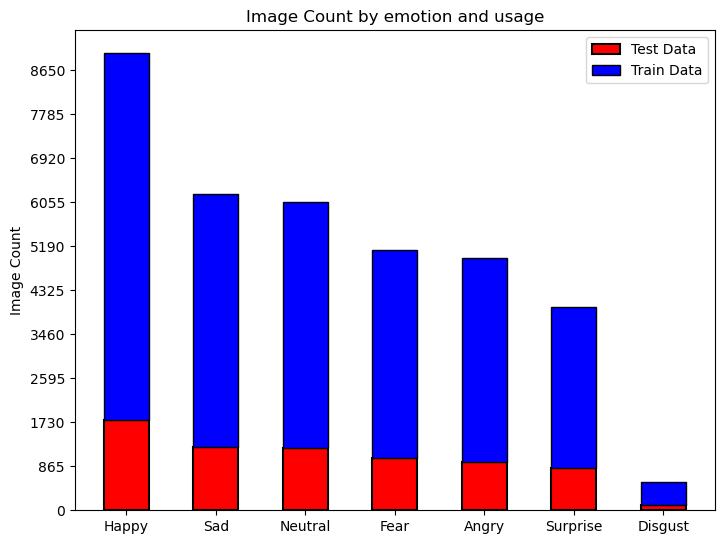

In [451]:
N = distribution_labels.groupby(level='usage').count()[0]

menMeans = distribution_labels.Test.values
womenMeans = distribution_labels.Training.values
ind = np.arange(N) # the x locations for the groups
width = 0.5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r', edgecolor='k', linewidth=1.5)
ax.bar(ind, womenMeans, width, bottom=menMeans, color='b', edgecolor='k', linewidth=1)
ax.set_ylabel('Image Count')
ax.set_title('Image Count by emotion and usage')
ax.set_xticks(ind, (distribution_labels.Test.keys()))
tick_no = (distribution_labels.max()*1.2)
ax.set_yticks(np.arange(0, tick_no, tick_no//10))
ax.legend(labels=['Test Data', 'Train Data'])
plt.show()

<class 'PIL.Image.Image'>


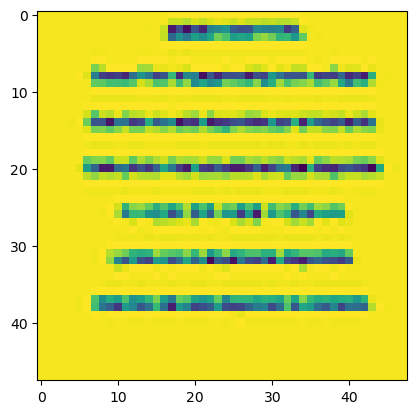

In [452]:
from tensorflow.keras.utils import array_to_img
m = face.pixels[7172].reshape(48,48,1)
img_pil = array_to_img(m)
print(type(img_pil))

# show image
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(img_pil)

In [ ]:
def find_corrupt_hash_key(pixel):
        pixel.apply(lambda x: np.sum(x))

In [481]:
#remove image duplicates efficiently
def delete_duplicate_img(face_df): 
    pixel_series = face_df['pixels']
    num_of_file_deleted = 0
    files_delete = []
    
    #number of images within each emotion class
    emotion_count = face_df['emotion'].value_counts()
    
    #give image pixels unique idendity (key) through hashing
    img_property = pixel_series.apply(lambda x: hash(x.tobytes()))
    
    #list out the image keys with occurances larger than 1
    unique_count = img_property.value_counts()
    to_remove_duplicates = unique_count.loc[unique_count>1] 
    
   
    for img_id in to_remove_duplicates.index:
        duplicates_idx = img_property[(img_property == img_id)].index

        #remove duplicates while keeping unique case
        #based off which category has the smallest dataset size in the emotion classes
        emotion_series = face_df['emotion'].iloc[duplicates_idx]

        emotion_to_keep = emotion_count[emotion_series.unique()].idxmin()

        idx_to_keep = emotion_series.loc[emotion_series==emotion_to_keep].index[0]
        duplicates_idx = duplicates_idx.tolist()

        duplicates_idx.remove(idx_to_keep)

        files_delete.extend(duplicates_idx)
        num_of_file_deleted += len(duplicates_idx)
        
    
    face_df.drop(files_delete, axis=0, inplace=True)
    print(f"{num_of_file_deleted} were duplicates. Duplicates deleted ...")
    return face_df


In [482]:
hh = face.copy()

In [483]:
rt = delete_duplicate_img(hh)
rt

1853 were duplicates. Duplicates deleted ...


,emotion,usage,pixels,label_name
0,0,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",Angry
1,0,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",Angry
2,2,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",Fear
3,4,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",Sad
4,6,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",Neutral
...,...,...,...,...
35881,0,Test,"[[181, 177, 176, 156, 178, 144, 136, 132, 122,...",Angry
35882,6,Test,"[[50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, ...",Neutral
35883,3,Test,"[[178, 174, 172, 173, 181, 188, 191, 194, 196,...",Happy
35884,0,Test,"[[17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, ...",Angry


In [467]:

m = [3808, 13141, 18784, 25060, 32865, 34944, 35012]
n = [3808, 13141, 18784, 25060, 32865, 43, 34]

m.extend(n)


In [468]:
m 

[3808,
 13141,
 18784,
 25060,
 32865,
 34944,
 35012,
 3808,
 13141,
 18784,
 25060,
 32865,
 43,
 34]

In [462]:
n = face.copy()
n['emotion'].iloc[m]

3808     0
13141    0
18784    0
25060    0
32865    0
34944    0
35012    0
Name: emotion, dtype: int64